In [1]:
# importacao de bibliotecas necessarias

# bibliotecas de redes neurais
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model

# bibliotecas de manipulacao de variaveis de ambiente e acesso a diretorios
import os, warnings
import glob

# bibliotecas de manipulacao e visualizacao de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preparação dos Dados

Retomamos a mesma preparação dos dados abordada na [primeira entrega](https://github.com/GFerrazzo/INE5644/blob/main/Primeira%20Entrega%20-%20Trabalho%20Final.ipynb). Dessa vez, retiramos os blocos de código com propósito de visualização da preparação.

In [2]:
# df = pd.read_csv('https://raw.githubusercontent.com/GFerrazzo/INE5644/main/KaggleV2-May-2016.csv', sep = ',')

df = pd.read_csv('KaggleV2-May-2016.csv', sep = ',')

In [3]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

In [4]:
df['Gender'] = df['Gender'].map({'M' : 1, 'F' : 0})
df['No-show'] = df['No-show'].map({'Yes' : 1, 'No' : 0})

# esse bloco foi alterado para nao utilizarmos mais o dtype boolean. o Keras teve algum problema em trabalhar com esse dtype.

In [5]:
df['ScheduleToAppointment'] = (df['AppointmentDay'] - df['ScheduledDay']).astype('timedelta64[D]') + 1

In [6]:
df['ScheduleWeekDay'] = df['ScheduledDay'].dt.weekday

In [7]:
df.drop(columns=['PatientId','AppointmentID','ScheduledDay','AppointmentDay'], inplace=True)

In [8]:
df.drop(df[df['Age'] < 0].index, inplace=True)

In [9]:
df.drop(df[df['ScheduleToAppointment'] < 0].index, inplace=True)

In [10]:
df[df['No-show'] == True].shape[0]/df.shape[0]

0.2018982817745044

In [11]:
df.drop(columns=['Neighbourhood'], inplace=True)

In [12]:
df['Age'] = pd.cut(df['Age'], bins=29, precision=0)

In [13]:
# df['Handcap'] = df['Handcap'].map({1 : True, 2 : True, 3 : True, 4 : True, 0 : False})

In [14]:
df['ScheduleToAppointment'] = pd.cut(df['ScheduleToAppointment'], bins=30, precision=0)

In [15]:
df.sample(5)

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduleToAppointment,ScheduleWeekDay
18263,1,"(-0.0, 4.0]",0,0,0,0,0,1,0,"(6.0, 12.0]",3
21132,0,"(28.0, 32.0]",1,0,0,0,0,0,0,"(-0.0, 6.0]",0
48197,1,"(63.0, 67.0]",0,0,0,0,0,0,0,"(-0.0, 6.0]",4
17243,0,"(16.0, 20.0]",1,0,0,0,1,0,0,"(-0.0, 6.0]",1
7082,1,"(48.0, 52.0]",0,0,0,0,0,1,1,"(6.0, 12.0]",0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110521 entries, 0 to 110526
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   Gender                 110521 non-null  int64   
 1   Age                    110521 non-null  category
 2   Scholarship            110521 non-null  int64   
 3   Hipertension           110521 non-null  int64   
 4   Diabetes               110521 non-null  int64   
 5   Alcoholism             110521 non-null  int64   
 6   Handcap                110521 non-null  int64   
 7   SMS_received           110521 non-null  int64   
 8   No-show                110521 non-null  int64   
 9   ScheduleToAppointment  110521 non-null  category
 10  ScheduleWeekDay        110521 non-null  int64   
dtypes: category(2), int64(9)
memory usage: 8.6 MB


In [17]:
df['Age'] = df['Age'].cat.codes
df['ScheduleToAppointment'] = df['ScheduleToAppointment'].cat.codes

# Primeiro Modelo

In [18]:
df_model = df.copy()

In [19]:
target = df_model.pop('No-show')

In [20]:
dataset = tf.data.Dataset.from_tensor_slices((df_model.values, target.values))

In [21]:
train_dataset = dataset.shuffle(len(df_model)).batch(32)

Começaremos com um modelo bem simples. Composto apenas por três camadas.

In [22]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(11, activation='relu'),
    tf.keras.layers.Dense(11, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

In [23]:
model1.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [24]:
model1_performance = model1.fit(train_dataset, epochs=5)

Epoch 1/5
3454/3454 [==============================] - 26s 7ms/step - loss: 0.4829 - accuracy: 0.7947
Epoch 2/5
3454/3454 [==============================] - 19s 5ms/step - loss: 0.4677 - accuracy: 0.7981
Epoch 3/5
3454/3454 [==============================] - 18s 5ms/step - loss: 0.4666 - accuracy: 0.7981
Epoch 4/5
3454/3454 [==============================] - 17s 5ms/step - loss: 0.4664 - accuracy: 0.7981
Epoch 5/5
3454/3454 [==============================] - 20s 6ms/step - loss: 0.4661 - accuracy: 0.7981


Como podemos notar, ao utilizar o dataset como ele foi fornecido, chegamos numa acurácia de 79.81%. 

Coincidentemente (veremos que não é coincidência), esse é o valor do balanço das nossas classes, como podemos ver:

In [25]:
df[df['No-show'] == True].shape[0]/df.shape[0]

0.2018982817745044

In [26]:
df[df['No-show'] == False].shape[0]/df.shape[0]

0.7981017182254956

Ou seja, podemos imaginar que nosso modelo está prevendo "Presença" para todas predições, mas só acerta 79.81% das vezes.
Podemos conferir isso com uma matriz de confusão.

In [27]:
y_pred_model1 = model1.predict(df_model)

In [28]:
tf.math.confusion_matrix(labels=target, predictions=y_pred_model1.ravel()>0.5)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[88207,     0],
       [22314,     0]])>

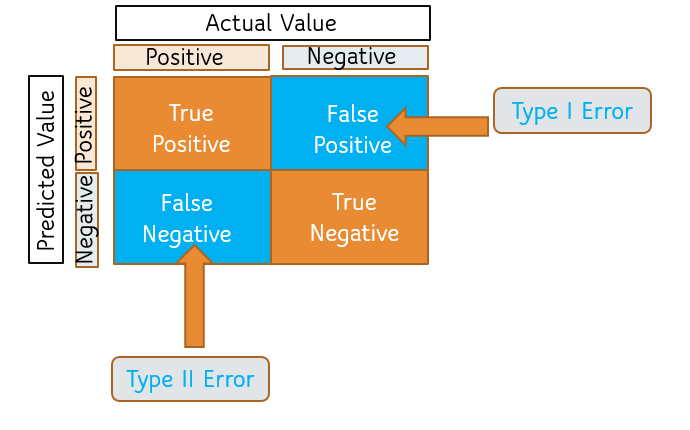

Comparando com a imagem acima (fonte), podemos notar que temos:
    88207 casos de positivos verdadeiros.
    22314 casos de falsos negativos.
    
Que nos dá a acurácia de 79.81%.

Indo além, podemos verificar pelo próprio resultado da predição, que retorna 110521 predições de "Falso":

In [29]:
y_pred_model1.ravel()>0.5

array([False, False, False, ..., False, False, False])

In [30]:
np.unique(y_pred_model1.ravel()>0.5, return_counts=True)

(array([False]), array([110521], dtype=int64))

# Segundo Modelo

O que notamos que aconteceu no primeiro modelo é o chamado "paradoxo da acurácia", onde descobrimos que a acurácia não é um método "certeiro" de medir a previsibilidade do nosso modelo. Devemos alterar dois itens no nosso primeiro modelo:
- Consertar o desbalanço das classes
- Alterar a métrica de cálculo da previsibilidade do modelo

Para o primeiro item acima, temos várias opções: undersampling, oversampling, etc. Porém, neste segundo modelo, vamos tentar alterar somente a métrica para ver o impacto que a métrica errada tinha sobre o modelo.

Temos inúmeras opções de métricas diferentes, citamos algumas, com suas nomenclaturas em inglês (para evitar traduções errôneas):
- Precision = TP/(TP+FP)
- Recall = TP/(TP+FN)
- F1 Score = 2 * Recall * Precision / (Recall + Precision)
- Area Under ROC Curve
- G-Measure = sqrt(Precision * Recall)
- Jaccard Index = TP/(TP+FP+FN)


onde 

TP = True Positive

FP = False Positive

FN = False Negative

In [49]:
df_model = df.copy()

target = df_model.pop('No-show')

dataset = tf.data.Dataset.from_tensor_slices((df_model.values, target.values))

train_dataset = dataset.shuffle(len(df_model)).batch(32)

model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(11, activation='relu'),
    tf.keras.layers.Dense(11, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

model2.compile(optimizer='sgd',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=[tf.keras.metrics.AUC()])

model2_performance = model2.fit(train_dataset, epochs=10)

Epoch 1/10
3454/3454 [==============================] - 25s 7ms/step - loss: 0.4943 - auc: 0.6118
Epoch 2/10
3454/3454 [==============================] - 23s 7ms/step - loss: 0.4767 - auc: 0.6610
Epoch 3/10
3454/3454 [==============================] - 23s 7ms/step - loss: 0.4731 - auc: 0.6701
Epoch 4/10
3454/3454 [==============================] - 23s 7ms/step - loss: 0.4710 - auc: 0.6758
Epoch 5/10
3454/3454 [==============================] - 23s 7ms/step - loss: 0.4699 - auc: 0.6785
Epoch 6/10
3454/3454 [==============================] - 23s 7ms/step - loss: 0.4690 - auc: 0.6810
Epoch 7/10
3454/3454 [==============================] - 23s 7ms/step - loss: 0.4687 - auc: 0.6819
Epoch 8/10
3454/3454 [==============================] - 23s 7ms/step - loss: 0.4682 - auc: 0.6838
Epoch 9/10
3454/3454 [==============================] - 23s 7ms/step - loss: 0.4680 - auc: 0.6841
Epoch 10/10
3454/3454 [==============================] - 23s 7ms/step - loss: 0.4678 - auc: 0.6848


Text(0.5, 1.0, 'AUC by epochs')

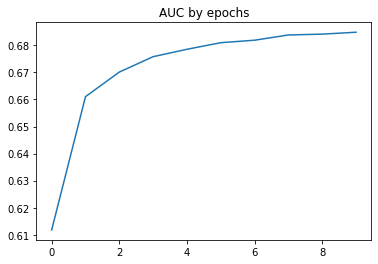

In [53]:
# Plot da acuracia de treino e validacao
plt.plot(model2_performance.history['auc'])
plt.title('AUC by epochs')

Text(0.5, 1.0, 'Loss by epochs')

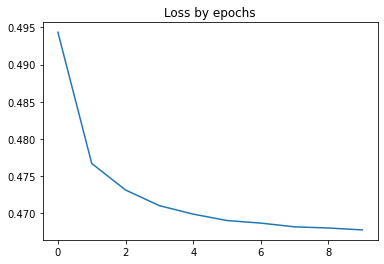

In [52]:
# Plot da acuracia de treino e validacao
plt.plot(model2_performance.history['loss'])
plt.title('Loss by epochs')

In [51]:
y_pred_model2 = model2.predict(df_model)
tf.math.confusion_matrix(labels=target, predictions=y_pred_model2.ravel()>0.5)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[88205,     2],
       [22313,     1]])>